<a href="https://colab.research.google.com/github/kmtsui/hobby_stock/blob/main/stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stock trend prediction from historic data

In [ ]:
from __future__ import absolute_import, division, print_function

import math

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping

# Check Versions
print(tf.__version__)

2.4.1


In [ ]:
# Additional tensorflow_addons is needed for the training
!pip install tensorflow-addons

In [ ]:
# Link to google drive for permanent storage
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Historic data you can get from https://www.macrotrends.net/stocks/research
# Remember to remove the first ~14 rows for data input
intel_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MacroTrends_Data_Download_INTC.csv",names=["date", "open", "high", "low", "close",
           "volume"])
intel_data.head()

,date,open,high,low,close,volume
0,date,open,high,low,close,volume
1,3/17/1980,0.1996,0.2028,0.1996,0.1996,10924800
2,3/18/1980,0.1996,0.2012,0.198,0.198,17068800
3,3/19/1980,0.2028,0.206,0.2028,0.2028,18508800
4,3/20/1980,0.2028,0.2052,0.202,0.202,11174400


In [ ]:
intel_features = intel_data.copy()
intel_features = np.array(intel_features)
intel_features = intel_features[1:]
intel_features

array([['3/17/1980', '0.1996', '0.2028', '0.1996', '0.1996', '10924800'],
       ['3/18/1980', '0.1996', '0.2012', '0.198', '0.198', '17068800'],
       ['3/19/1980', '0.2028', '0.206', '0.2028', '0.2028', '18508800'],
       ...,
       ['4/16/2021', '65.33', '65.52', '64.57', '64.75', '24625458'],
       ['4/19/2021', '64.7', '64.74', '63.07', '63.63', '23997675'],
       ['4/20/2021', '63.64', '63.76', '62.41', '62.7', '19872123']],
      dtype=object)

In [ ]:
nPoints = 200
nPoints_after = 10
def get_train_data(filename):
  raw_data = pd.read_csv(filename,names=["date", "open", "high", "low", "close", "volume"])
  feature_array = raw_data.copy()
  feature_array = np.array(feature_array)
  feature_array = feature_array[1:]
  feature_array = feature_array[len(feature_array)-4000:len(feature_array)]
  volume = np.asfarray(feature_array[:,5],float)
  close_value = feature_array[:,4]
  xvalue_array = np.empty(shape=(len(feature_array)-nPoints-nPoints_after,2*nPoints))
  yvalue_array = np.empty(len(feature_array)-nPoints-nPoints_after)
  weigths_array = np.empty(len(feature_array)-nPoints-nPoints_after)
  for i in range(len(feature_array)-nPoints-nPoints_after):
    tmp_array = np.empty(nPoints)
    volume_array = np.empty(nPoints)
    #float(close_value[i:i+nPoints])
    for j in range(nPoints):
      tmp_array[j]=close_value[i+j]
      volume_array[j]=volume[i+j]
    tmp_array = tmp_array/np.mean(tmp_array)-1
    volume_array = volume_array/np.mean(volume_array)-1
    xvalue_array[i]=np.concatenate([tmp_array,volume_array])
    yvalue_array[i] = np.heaviside(float(close_value[i+nPoints-1+nPoints_after])-float(close_value[i+nPoints-1]),0)
    weigths_array[i] = abs(float(close_value[i+nPoints-1+nPoints_after])-float(close_value[i+nPoints-1]))/float(close_value[i+nPoints-1])
  return xvalue_array, yvalue_array, weigths_array, np.asfarray(close_value,float)
intel_xvalue,  intel_yvalue, intel_weights, intel_close=get_train_data("/content/drive/MyDrive/Colab Notebooks/MacroTrends_Data_Download_INTC.csv")
hsbc_xvalue,  hsbc_yvalue, hsbc_weights, hsbc_close=get_train_data("/content/drive/MyDrive/Colab Notebooks/MacroTrends_Data_Download_HSBC.csv")
jnj_xvalue,  jnj_yvalue, jnj_weights, jnj_close=get_train_data("/content/drive/MyDrive/Colab Notebooks/MacroTrends_Data_Download_JNJ.csv")
tm_xvalue,  tm_yvalue, tm_weights, tm_close=get_train_data("/content/drive/MyDrive/Colab Notebooks/MacroTrends_Data_Download_TM.csv")
dis_xvalue,  dis_yvalue, dis_weights, dis_close=get_train_data("/content/drive/MyDrive/Colab Notebooks/MacroTrends_Data_Download_DIS.csv")

In [ ]:
len(dis_close)

4000

In [ ]:
# set up the DNN model for training
inputs = Input((2*nPoints, )) # nPoints-d vector as input
hidden_layer_1 = Dense(800, activation='relu')(inputs)
dropout_layer_1 = Dropout(0.5)(hidden_layer_1)
hidden_layer_2 = Dense(400, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(0.5)(hidden_layer_2)
hidden_layer_3 = Dense(200, activation='relu')(dropout_layer_2)
dropout_layer_3 = Dropout(0.5)(hidden_layer_3)
outputs = Dense(1, activation='sigmoid')(dropout_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=50, 
                              verbose=1,
                              restore_best_weights=True)

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow_addons.optimizers import AdamW

#xvalue = intel_xvalue
#yvalue = intel_yvalue 
#weights = intel_weights

xvalue = np.concatenate([intel_xvalue,hsbc_xvalue,jnj_xvalue])
yvalue = np.concatenate([intel_yvalue,hsbc_yvalue,jnj_yvalue])
weights = np.concatenate([intel_weights,hsbc_weights,jnj_weights])

layer_reco = preprocessing.Normalization()
layer_reco.adapt(xvalue)
xvalue_norm = layer_reco(xvalue).numpy()

#X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvalue_norm, yvalue, weights)
X_train_1, Y_train_1, w_train_1=xvalue_norm, yvalue, weights
X_test_1, Y_test_1, w_test_1 = layer_reco(np.concatenate([tm_xvalue,dis_xvalue])).numpy(), np.concatenate([tm_yvalue,dis_yvalue]), np.concatenate([tm_weights,dis_weights])

optimizer = AdamW(weight_decay=0.0001)#,learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              #optimizer='Adam',
              optimizer= optimizer,
              metrics=['accuracy'])
model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=1000,
          batch_size=64,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=1)

Epoch 1/1000
178/178 [==============================] - 4s 19ms/step - loss: 0.0282 - accuracy: 0.5153 - val_loss: 0.0229 - val_accuracy: 0.5369
Epoch 2/1000
178/178 [==============================] - 2s 14ms/step - loss: 0.0252 - accuracy: 0.5174 - val_loss: 0.0228 - val_accuracy: 0.5435
Epoch 3/1000
178/178 [==============================] - 2s 14ms/step - loss: 0.0227 - accuracy: 0.5433 - val_loss: 0.0230 - val_accuracy: 0.5480
Epoch 4/1000
178/178 [==============================] - 3s 14ms/step - loss: 0.0218 - accuracy: 0.5656 - val_loss: 0.0229 - val_accuracy: 0.5468
Epoch 5/1000
178/178 [==============================] - 3s 14ms/step - loss: 0.0215 - accuracy: 0.5753 - val_loss: 0.0229 - val_accuracy: 0.5380
Epoch 6/1000
178/178 [==============================] - 3s 14ms/step - loss: 0.0202 - accuracy: 0.6001 - val_loss: 0.0238 - val_accuracy: 0.5323
Epoch 7/1000
178/178 [==============================] - 3s 14ms/step - loss: 0.0198 - accuracy: 0.5949 - val_loss: 0.0239 - val_ac

In [ ]:
def make_predictions(events, close_value):
  events_norm = layer_reco(events).numpy()
  f = model.predict(events_norm, batch_size=64)
  predictions = np.empty(len(f))
  for i in range(len(events)):
    predictions[i] = (f[i]-0.5)*2*abs(close_value[i+nPoints-1+nPoints_after]-close_value[i+nPoints-1])+close_value[i+nPoints-1]
  return predictions
intel_predictions = make_predictions(intel_xvalue,intel_close)

Win = 2111, Lose = 1673, Profit = 21.89843908856276


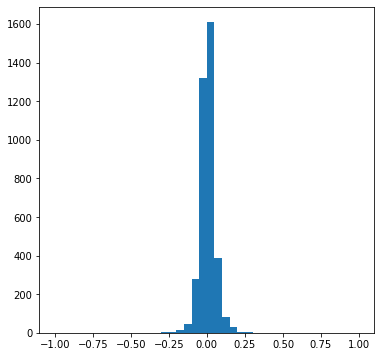

In [ ]:
def revenue(events, close_value):
  buy = 0.5
  sell = 0.5
  profit = 0
  record=[]
  win = 0
  lose = 0 
  events_norm = layer_reco(events).numpy()
  f = model.predict(events_norm, batch_size=64)
  for i in range(len(events)):
    result = 0 
    if f[i]>buy:
      result = close_value[i+nPoints-1+nPoints_after]/close_value[i+nPoints-1]-1
      record.append(result)
    if f[i]<sell:
      result = 1-close_value[i+nPoints-1+nPoints_after]/close_value[i+nPoints-1]
      record.append(result)
    if result>0:
      win = win+1
    elif result<0:
      lose=lose+1
    profit=profit+result
  return win, lose, profit, np.array(record)
win, lose, profit, record = revenue(dis_xvalue,dis_close)
print('Win = {}, Lose = {}, Profit = {}'.format(win, lose, profit))

bins = np.linspace(-1, 1, 41)

fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(record,bins=bins)

plt.show()

In [ ]:
record

In [ ]:
d

[1]

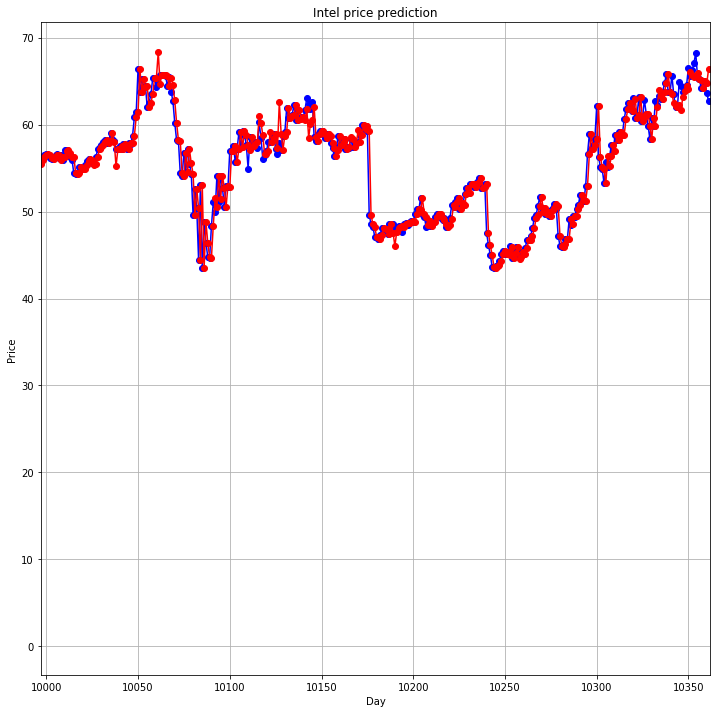

In [ ]:
# Data for plotting
day = np.arange(0, len(intel_close), 1)
price = intel_close

day_pred = np.arange(nPoints+nPoints_after, nPoints+nPoints_after+len(intel_predictions) , 1)
price_pred = intel_predictions

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(day, price, '-o', label='real', color='blue')
ax.plot(day_pred, price_pred, '-o', label='predicted',color="red")

ax.set(xlabel='Day', ylabel='Price',
       title='Intel price prediction')
ax.grid()

plt.xlim([len(intel_close)-365,len(intel_close)])

plt.show()

In [ ]:
len(intel_predictions)

10152

In [ ]:
len(intel_close)

10362

In [ ]:
intel_xvalue_norm[0]

array([ 0.71552014,  0.5894576 ,  1.5162296 ,  1.5691782 ,  0.10943511,
       -0.7938307 , -0.59021366, -0.8156513 , -1.675015  , -0.5322857 ],
      dtype=float32)